$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## Thresholding with false discovery rate

Written with J-B Poline.

The false discovery rate is a different *type* of correction than
family-wise correction. Instead of controlling for the risk of *any
tests* falsely being declared significant under the null hypothesis, FDR
will control the *number of tests falsely declared significant as a
proportion of the number of all tests declared significant*.

A basic idea on how the FDR works is the following.

We have got a large number of p values from a set of individual tests.
These might be p values from tests on a set of brain voxels.

We are trying to a find a p value threshold $\theta$ to do a
reasonable job of distinguishing true positive tests from true
negatives. p values that are less than or equal to $\theta$ are
*detections* and $\theta$ is a *detection threshold*.

We want to choose a detection threshold that will only allow a small
number of false positive detections.

A *detection* can also be called a *discovery*; hence false discovery
rate.

For the FDR, we will try to find a p value within the family of tests
(the set of p values), that we can use as a detection threshold.

Let’s look at the p value for a particular test. Let’s say there are
$N$ tests, indexed with $i \in 1 .. N$. We look at a test
$i$, and consider using p value from this test as a detection
threshold; $\theta = p(i)$. The expected number of false positives
(FP) in N tests at this detection threshold would be:

$$
E(FP) = N p(i)
$$

For example, if we had 100 tests, and the particular p value
$p(i)$ was 0.1, then the expected number of false positive
detections, thresholding at 0.1, is 0.1 \* 100 = 10.

Let’s take some data from a random normal distribution to illustrate:

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
np.random.seed(42) # so we always get the same random numbers
N = 100
z_values = np.random.normal(size=N)

Turn the Z values into p values:

In [5]:
import scipy.stats as sst
normal_distribution = sst.norm(loc=0,scale=1.) #loc is the mean, scale is the variance.
# The normal CDF
p_values = normal_distribution.cdf(z_values)

To make it easier to show, we sort the p values from smallest to
largest:

Text(0, 0.5, 'p value')

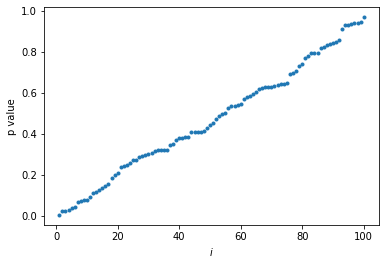

In [6]:
p_values = np.sort(p_values)
i = np.arange(1, N+1) # the 1-based i index of the p values, as in p(i)
plt.plot(i, p_values, '.')
plt.xlabel('$i$')
plt.ylabel('p value')

Notice the (more or less) straight line of p value against $i$
index in this case, where there is no signal in the random noise.

We want to find a p value threshold $p(i)$ where there is only a
small *proportion* of false positives among the detections. For example,
we might accept a threshold such that 5% of all detections (discoveries)
are likely to be false positives. If $d$ is the number of
discoveries at threshold $\theta$, and $q$ is the proportion
of false positives we will accept (e.g. 0.05), then we want a threshold
$\theta$ such that $E(FP) / d < q$ where $E(x)$ is the
expectation of $x$, here the number of FP I would get *on average*
if I was to repeat my experiment many times.

So - what is $d$ in the plot above? Now that we have ordered the p
values, for any index $i$, if we threshold at
$\theta \le p(i)$ we will have $i$ detections
($d = i$). Therefore we want to find the largest $p(i)$ such
that $E(FP) / i < q$. We know $E(FP) = N p(i)$ so we want
the largest $p(i)$ such that:

$$
N p(i) / i < q \implies p(i) < q i / N
$$

Let’s take $q$ (the proportion of false discoveries = detections)
as 0.05. We plot $q i / N$ (in red) on the same graph as
$p(i)$ (in blue):

In [ ]:
q = 0.05
plt.plot(i, p_values, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

Our job is to look for the largest $p(i)$ value (blue dot) that is
still underneath $q i / N$ (the red line).

The red line $q i / N$ is the acceptable number of false positives
$q i$ as a proportion of all the tests $N$. Further to the
right on the red line corresponds to a larger acceptable number of false
positives. For example, for $i = 1$, the acceptable number of
false positives $q * i$ is $0.05 * 1$, but at
$i = 50$, the acceptable number of expected false positives
$q * i$ is $0.05 * 50 = 2.5$.

Notice that, if only the first p value passes threshold, then
$p(1) < q \space 1 \space / \space N$. So, if $q = 0.05$,
$p(1) < 0.05 / N$. This is the Bonferroni correction for $N$
tests.

The FDR becomes more interesting when there is signal in the noise. In
this case there will be p values that are smaller than expected on the
null hypothesis. This causes the p value line to start below the
diagonal on the ordered plot, because of the high density of low p
values.

In [ ]:
N_signal = 20
N_noise = N - N_signal
noise_z_values = np.random.normal(size=N_noise)
# Add some signal with very low z scores / p values
signal_z_values = np.random.normal(loc=-2.5, size=N_signal)
mixed_z_values = np.sort(np.concatenate((noise_z_values, signal_z_values)))
mixed_p_values = normal_distribution.cdf(mixed_z_values)
plt.plot(i, mixed_p_values, 'b.', label='$p(i)$')
plt.plot(i, q * i / N, 'r', label='$q i / N$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

The interesting part is the beginning of the graph, where the blue p
values stay below the red line:

In [ ]:
first_i = i[:30]
plt.plot(first_i, mixed_p_values[:30], 'b.', label='$p(i)$')
plt.plot(first_i, q * first_i / N, 'r', label='$q i / N$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

We are looking for the largest $p(i) < qi/N$, which corresponds to
the last blue point below the red line.

In [ ]:
below = mixed_p_values < (q * i / N) # True where p(i)<qi/N
max_below = np.max(np.where(below)[0]) # Max Python array index where p(i)<qi/N
print('p_i:', mixed_p_values[max_below])
print('i:', max_below + 1) # Python indices 0-based, we want 1-based

The Bonferroni threshold is:

In [ ]:
0.05 / N

In this case, where there is signal in the noise, the FDR threshold
*adapts* to the presence of the signal, by taking into account that some
values have small enough p values that they can be assumed to be signal,
so that there are fewer noise comparisons to correct for, and the
threshold is correspondingly less stringent.

As the FDR threshold becomes less stringent, the number of detections
increases, and the expected number of false positive detections
increases, because the FDR controls the *proportion* of false positives
in the detections. In our case, the expected number of false positives
in the detections is $q i = 0.05 * 9 = 0.45$. In other words, at
this threshold, we have a 45% chance of seeing a false positive among
the detected positive tests.

So, there are a number of interesting properties of the FDR - and some
not so interesting if you want to do brain imaging.

* In the case of no signal at all, the FDR threshold will be the
  Bonferroni threshold

* Under some conditions (see Benjamini and Hochberg, JRSS-B 1995), the
  FDR threshold can be applied to correlated data

* FDR is an “adaptive” threshold

Not so “interesting”

* FDR can be very variable

* When there are lots of true positives, and many detections, the
  number of false positive detections increases. This can make FDR
  detections more difficult to interpret.